In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import numpy as np 
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from debris_cover_smb import glac_dyn, constants, geospatial
import rasterio
from rasterio import features

## Notebook Purpose: Analyse senstivity of melt based thresholding to manually digitzed cliffs over Black Changri Nup Glacier

In [3]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/BlackChangriNup/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/BlackChangriNup


In [4]:
cliff_area1 = gpd.read_file('cliff_manual/cliff_time1.gpkg').make_valid()
cliff_area2 = gpd.read_file('cliff_manual/cliff_time2.gpkg').make_valid()

In [5]:
union_cliff = gpd.GeoDataFrame(geometry=cliff_area1.union(cliff_area2)).dissolve().explode()

/tmp/ipykernel_30383/3712591383.py:1: UserWarning: The indices of the two GeoSeries are different.
  union_cliff = gpd.GeoDataFrame(geometry=cliff_area1.union(cliff_area2)).dissolve().explode()
/tmp/ipykernel_30383/3712591383.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  union_cliff = gpd.GeoDataFrame(geometry=cliff_area1.union(cliff_area2)).dissolve().explode()


In [6]:
dem1_fn = 'dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif'
slope1_fn = 'dem/20151102_0517_10400100125E8E00_10400100130D8500_align_slope.tif'
slope2_fn = 'dem/20161025_0524_104001002469AD00_1040010024438E00-DEM_2m_align_flow_corrected_slope.tif'
slope_corrected_lagdhdt_fn = 'SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_slope_corrected_lagrangian_dhdt.tif'
debris_fn = constants.fetch_rounce_debris_thickness('changri_nup')
H_fn = constants.fetch_farinotti_thickness('changri_nup')
ds_list = warplib.memwarp_multi_fn([dem1_fn,slope1_fn,slope2_fn,slope_corrected_lagdhdt_fn,debris_fn,H_fn],extent='first')
ds_extent = geolib.ds_extent(ds_list[0])
fig_extent = [ds_extent[0],ds_extent[2],ds_extent[1],ds_extent[3]]


Warping all inputs to the following:
Resolution: 2.0
Extent: [474665.0, 3090517.0, 488435.0, 3100917.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif
2 of 6: dem/20151102_0517_10400100125E8E00_10400100130D8500_align_slope.tif
3 of 6: dem/20161025_0524_104001002469AD00_1040010024438E00-DEM_2m_align_flow_corrected_slope.tif
nl: 5200 ns: 6885 res: 2.000
0...10...20...30...40...50...60...70...80...90.4 of 6: SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_slope_corrected_lagrangian_dhdt.tif
5 of 6: /nobackupp11/sbhusha1/reference_data/debris_thickness/HMA_DTE_15.03734_hdts_m.tif
nl: 5200 ns: 6885 res: 2.000
..100 - done.
0...10...20...30...40...50...60...70...80...90.6 of 6: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.03734_thickness.tif
nl: 5200 ns: 6885 res: 2.000
..100 - done.
0...10...20...30...40...50...60...70...80...90.

<Axes: >

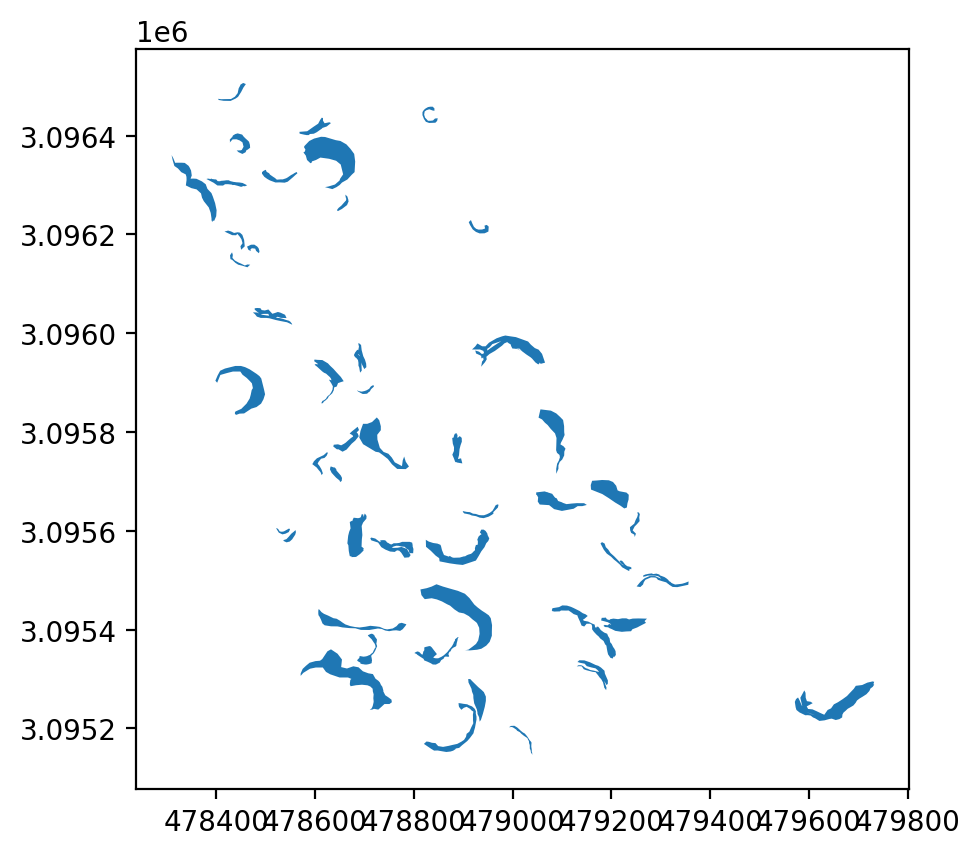

In [7]:
f,ax = plt.subplots()
union_cliff.plot(ax=ax)

In [8]:
dem1,slope1,slope2,slope_corrected_lagdhdt,debris,H = [iolib.ds_getma(ds) for ds in ds_list]
slope1 = np.ma.array(slope1,mask=debris.mask)
slope2 = np.ma.array(slope2,mask=debris.mask)
slope_corrected_lagdhdt = np.ma.array(slope_corrected_lagdhdt,mask=debris.mask)

In [9]:
glac_shp = gpd.read_file('/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp')
debris = geospatial.mask_by_shp(glac_shp.geometry,debris,ds=ds_list[-1])

In [10]:
raster_shape = iolib.ds_getma(ds_list[0]).shape
transform = rasterio.open(dem1_fn).transform
def confusion_matrix(cliff_gdf,truth_gdf,debris_raster,transform):
    cliff_study = features.rasterize(shapes=cliff_gdf.geometry, fill=0,out_shape=debris_raster.shape, transform=transform)
    cliff_truth = features.rasterize(shapes=truth_gdf.geometry, fill=0,out_shape=debris_raster.shape, transform=transform)
    true_positive = cliff_study*cliff_truth
    # false negative is threshold 0 truth 1
    false_negative = (cliff_truth==1) & (cliff_study == 0)
    # false positive is truth 0 threshold 1
    false_positive = (cliff_truth==0) & (cliff_study == 1)
    # true_negative is truth is 0, threshold is 0
    true_negative = np.ma.array(((cliff_truth ==0) & (cliff_study ==0)),mask=debris.mask)
    return true_positive,true_negative,false_positive,false_negative

In [11]:
from tqdm import tqdm

In [12]:
melt_threshold_list = np.arange(-3.5,-1.5,0.1)
cliff_outline_list = [glac_dyn.high_slope_high_melt(slope1,slope2,slope_corrected_lagdhdt,ds_list[0],slope_cutoff=10,dhdt_cutoff=melt,debris_cover_area=debris,min_pixel_count=15) for melt in tqdm(melt_threshold_list)]


100%|███████████████████████████████████████████| 20/20 [08:26<00:00, 25.31s/it]


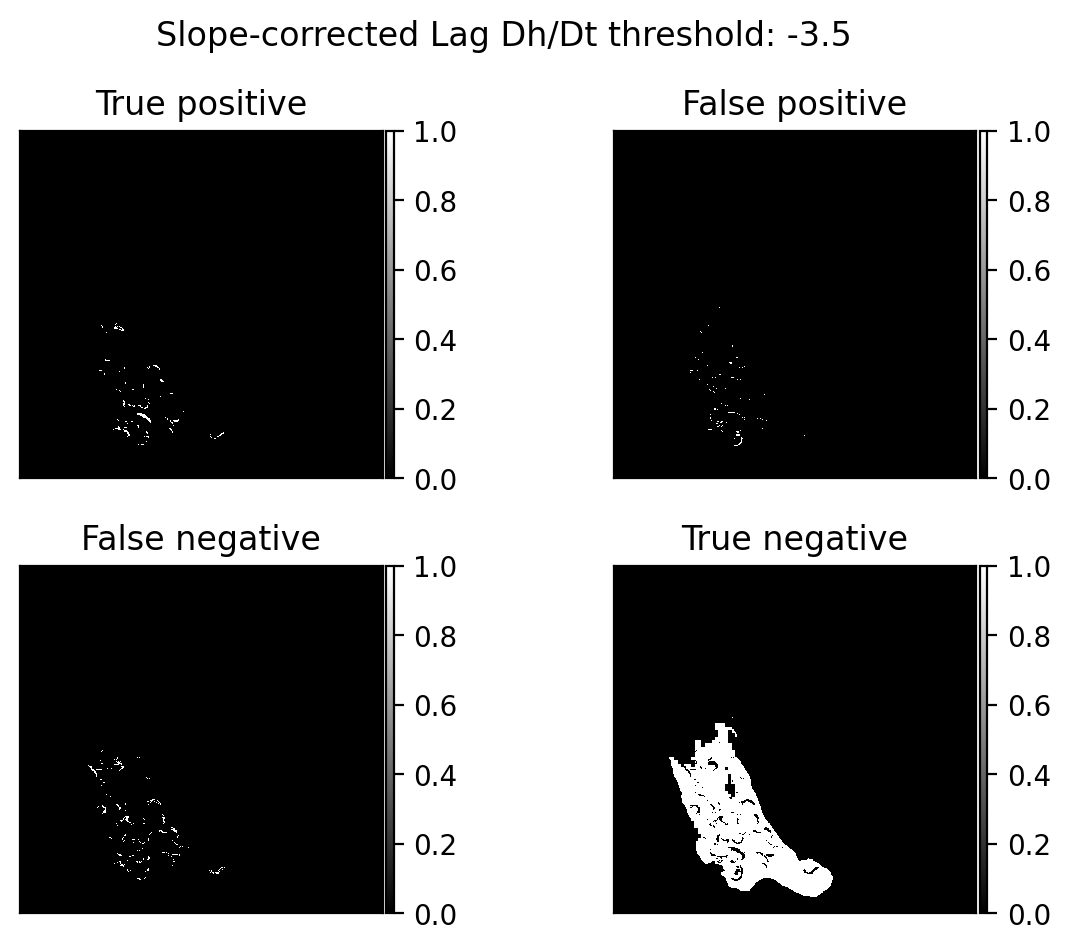

In [14]:
true_positive,true_negative,false_positive,false_negative = confusion_matrix(cliff_outline_list[0],union_cliff,debris,transform)
f,axa = plt.subplots(2,2,sharex=True,sharey=True)
ax = axa.ravel()
pltlib.iv(true_positive,ax=ax[0],clim=(0,1),cmap='gray',title='True positive',extent=fig_extent)
pltlib.iv(false_positive,ax=ax[1],clim=(0,1),cmap='gray',title='False positive',extent=fig_extent)
pltlib.iv(false_negative,ax=ax[2],clim=(0,1),cmap='gray',title='False negative',extent=fig_extent)
pltlib.iv(true_negative,ax=ax[3],clim=(0,1),cmap='gray',title='True negative',extent=fig_extent)
#pltlib.iv(true_negative,ax=ax,clim=(0,1),cmap='gray')
for ax in axa.ravel():
    ax.set_xlim(477599.7040301451, 481379.6298482157)
    ax.set_ylim(3094811.880500241, 3098430.95841116)
f.suptitle(f'Slope-corrected Lag Dh/Dt threshold: {melt_threshold_list[0]:.1f}')
plt.tight_layout()

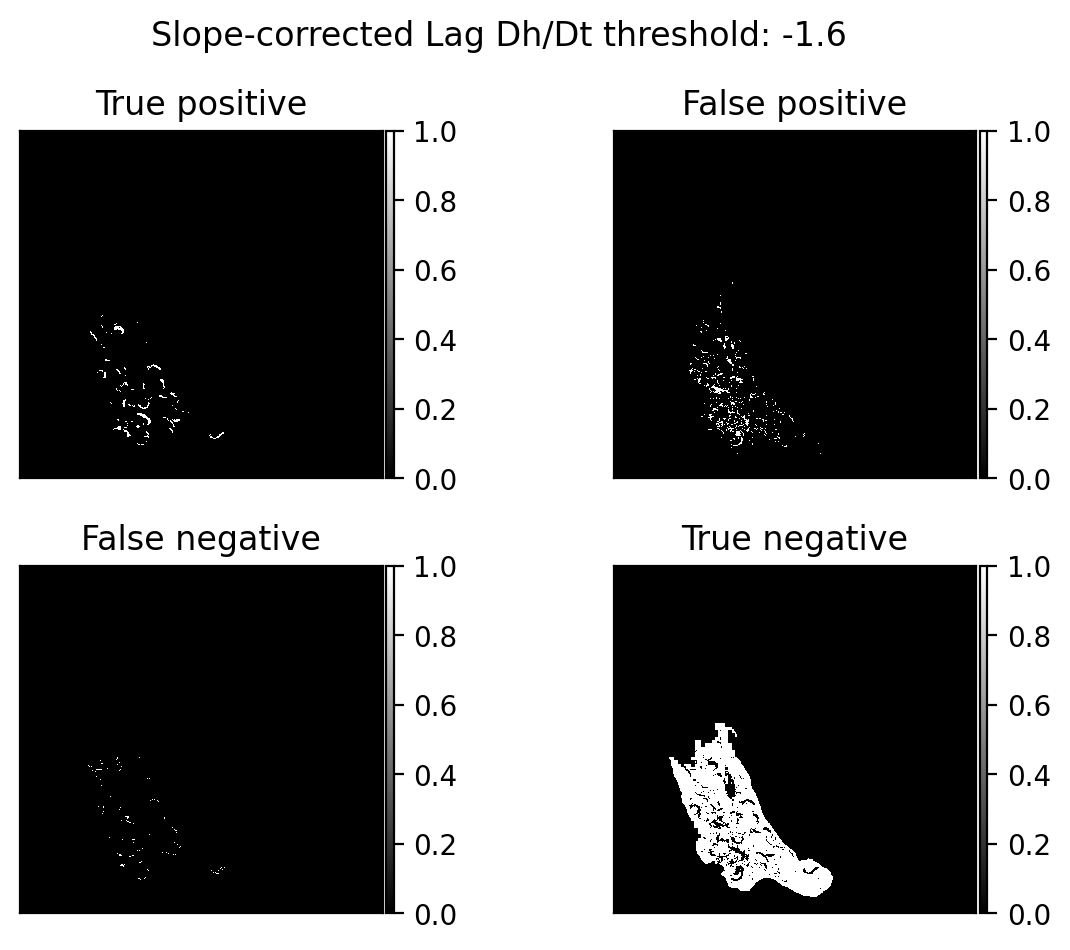

In [15]:
true_positive,true_negative,false_positive,false_negative = confusion_matrix(cliff_outline_list[-1],union_cliff,debris,transform)
f,axa = plt.subplots(2,2,sharex=True,sharey=True)
ax = axa.ravel()
pltlib.iv(true_positive,ax=ax[0],clim=(0,1),cmap='gray',title='True positive',extent=fig_extent)
pltlib.iv(false_positive,ax=ax[1],clim=(0,1),cmap='gray',title='False positive',extent=fig_extent)
pltlib.iv(false_negative,ax=ax[2],clim=(0,1),cmap='gray',title='False negative',extent=fig_extent)
pltlib.iv(true_negative,ax=ax[3],clim=(0,1),cmap='gray',title='True negative',extent=fig_extent)
#pltlib.iv(true_negative,ax=ax,clim=(0,1),cmap='gray')
for ax in axa.ravel():
    ax.set_xlim(477599.7040301451, 481379.6298482157)
    ax.set_ylim(3094811.880500241, 3098430.95841116)
f.suptitle(f'Slope-corrected Lag Dh/Dt threshold: {melt_threshold_list[-1]:.1f} ')
plt.tight_layout()

In [22]:
melt_threshold_list

array([-3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9, -2.8, -2.7, -2.6, -2.5,
       -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6])

In [58]:
%matplotlib widget

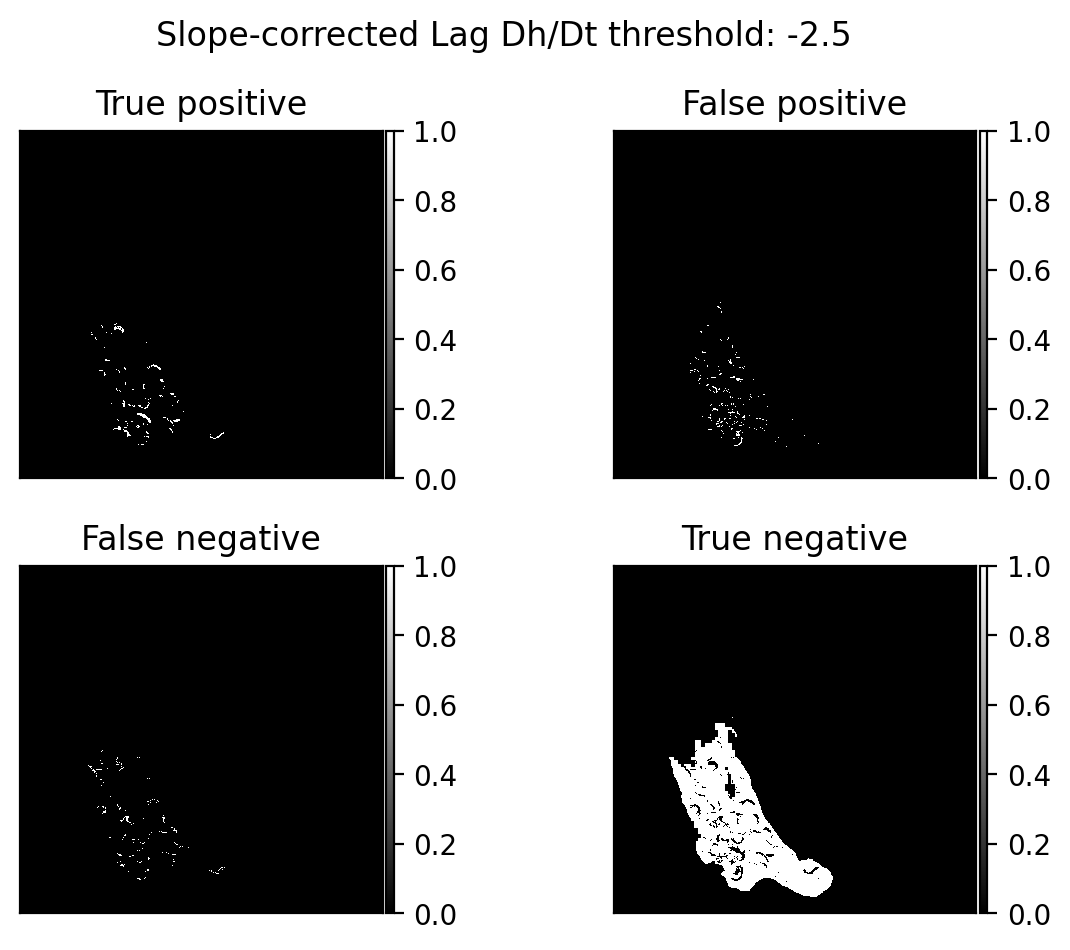

In [16]:
true_positive,true_negative,false_positive,false_negative = confusion_matrix(cliff_outline_list[10],union_cliff,debris,transform)
f,axa = plt.subplots(2,2,sharex=True,sharey=True)
ax = axa.ravel()
pltlib.iv(true_positive,ax=ax[0],clim=(0,1),cmap='gray',title='True positive',extent=fig_extent)
pltlib.iv(false_positive,ax=ax[1],clim=(0,1),cmap='gray',title='False positive',extent=fig_extent)
pltlib.iv(false_negative,ax=ax[2],clim=(0,1),cmap='gray',title='False negative',extent=fig_extent)
pltlib.iv(true_negative,ax=ax[3],clim=(0,1),cmap='gray',title='True negative',extent=fig_extent)
#pltlib.iv(true_negative,ax=ax,clim=(0,1),cmap='gray')
for ax in axa.ravel():
    ax.set_xlim(477599.7040301451, 481379.6298482157)
    ax.set_ylim(3094811.880500241, 3098430.95841116)
f.suptitle(f'Slope-corrected Lag Dh/Dt threshold: {melt_threshold_list[10]:.1f}')
plt.tight_layout()

In [66]:
%matplotlib widget

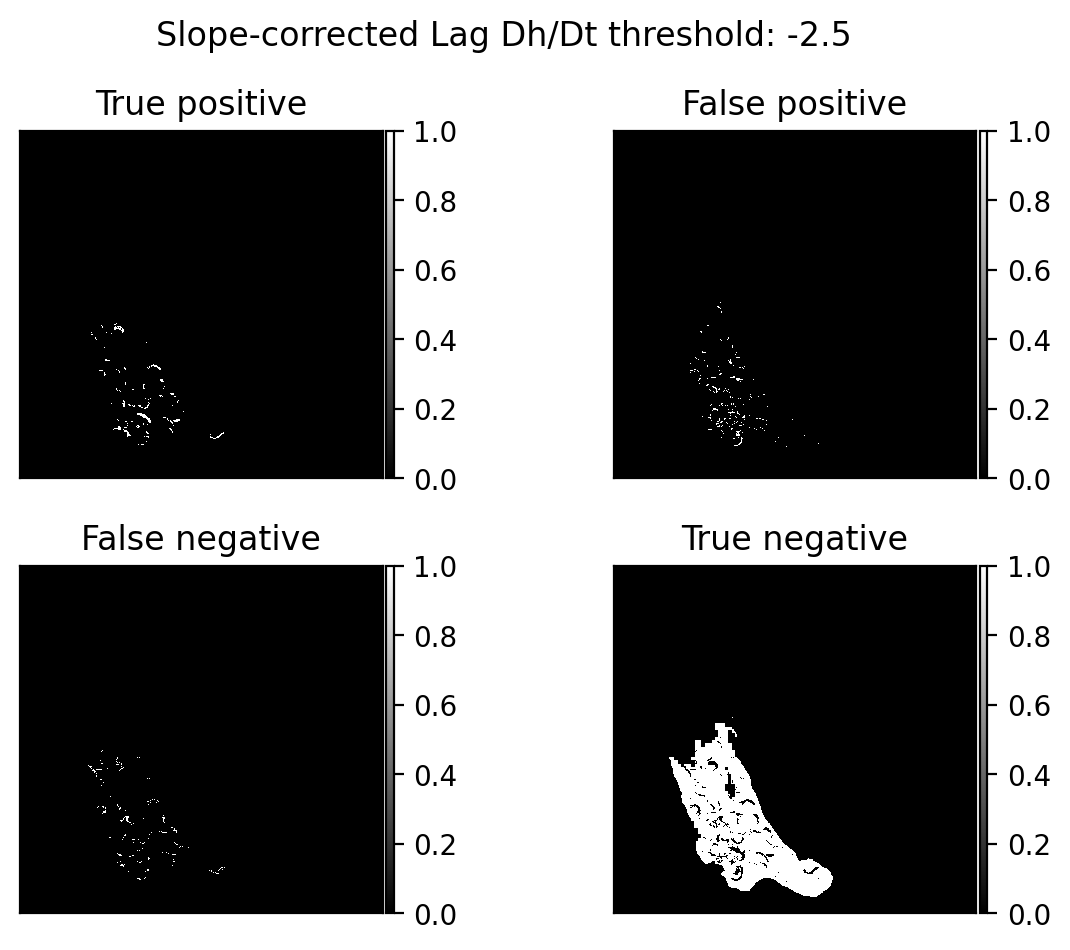

In [17]:
true_positive,true_negative,false_positive,false_negative = confusion_matrix(cliff_outline_list[10],union_cliff,debris,transform)
f,axa = plt.subplots(2,2,sharex=True,sharey=True)
ax = axa.ravel()
pltlib.iv(true_positive,ax=ax[0],clim=(0,1),cmap='gray',title='True positive',extent=fig_extent)
pltlib.iv(false_positive,ax=ax[1],clim=(0,1),cmap='gray',title='False positive',extent=fig_extent)
pltlib.iv(false_negative,ax=ax[2],clim=(0,1),cmap='gray',title='False negative',extent=fig_extent)
pltlib.iv(true_negative,ax=ax[3],clim=(0,1),cmap='gray',title='True negative',extent=fig_extent)
#pltlib.iv(true_negative,ax=ax,clim=(0,1),cmap='gray')
for ax in axa.ravel():
    ax.set_xlim(477599.7040301451, 481379.6298482157)
    ax.set_ylim(3094811.880500241, 3098430.95841116)
f.suptitle(f'Slope-corrected Lag Dh/Dt threshold: {melt_threshold_list[10]:.1f}')
plt.tight_layout()

In [18]:
def compute_dice_accuracy(cliff_gdf,truth_gdf,debris_raster,transform):
    true_positive,true_negative,false_positive,false_negative = confusion_matrix(cliff_gdf,truth_gdf,debris_raster,transform)
    dice_coef = (2*np.sum(true_positive))/(
        2*np.sum(true_positive)+np.sum(false_negative)+np.sum(false_positive))
    accuracy = (np.sum(true_positive)+np.ma.sum(true_negative))/(
        np.sum(true_positive)+np.ma.sum(true_negative)+np.sum(false_negative)+np.sum(false_positive))
    return dice_coef,accuracy

In [19]:
dice_list = []
accuracy_list = []
for cliff_outline in cliff_outline_list:
    dice,accuracy = compute_dice_accuracy(cliff_outline,union_cliff,debris,transform)
    dice_list.append(dice)
    accuracy_list.append(accuracy)

Text(0.5, 0, 'Slope-corrected Lag Dh/Dt threshold')

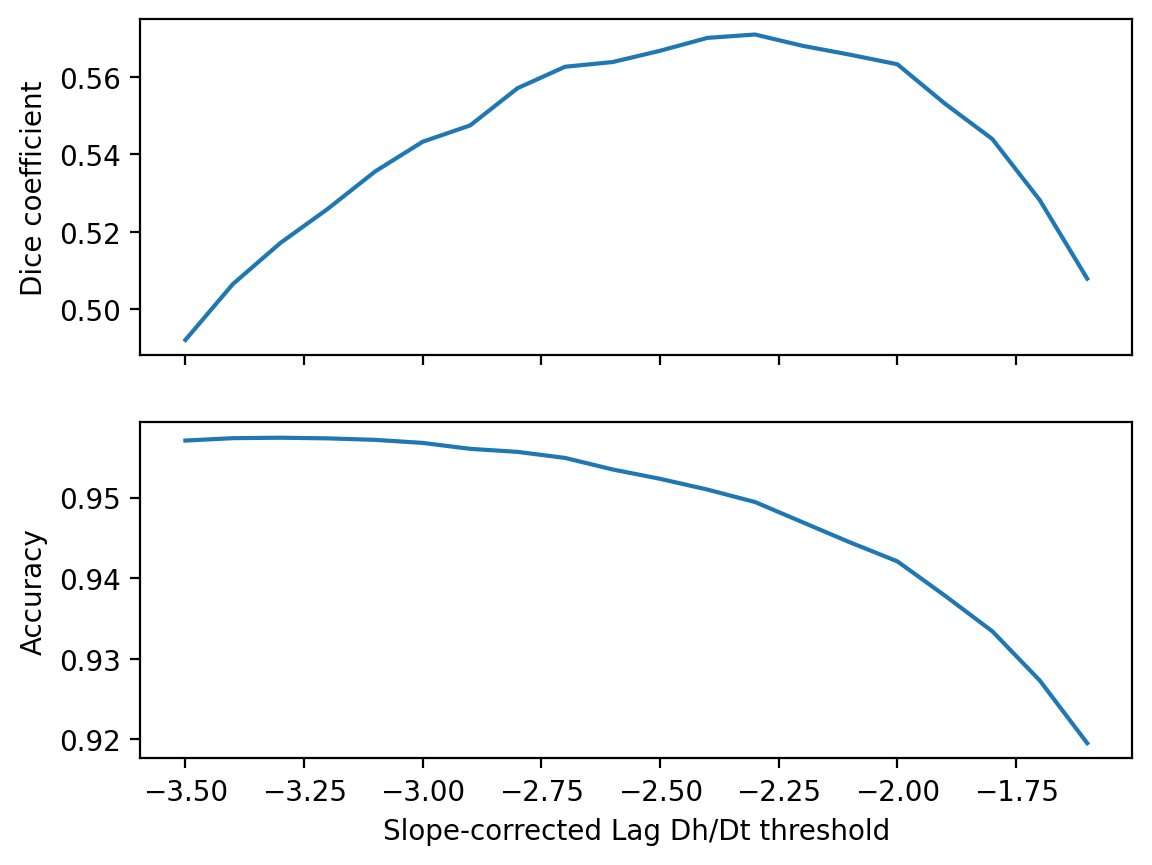

In [20]:
f,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(melt_threshold_list,dice_list)
ax[0].set_ylabel('Dice coefficient')
ax[1].plot(melt_threshold_list,accuracy_list)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel(f'Slope-corrected Lag Dh/Dt threshold')

In [35]:
np.max(dice)

0.5079488324242483

In [21]:
max_dice_coef = np.max(dice_list)

melt_threshold_dice_coef_max = melt_threshold_list[np.where(np.array(dice_list)==max_dice_coef)[0]][0]
print(f"max dice coefficient is {max_dice_coef :.3f}, for Slope-corrected Lag Dh/Dt threshold of {melt_threshold_dice_coef_max :.1f}")

max dice coefficient is 0.571, for Slope-corrected Lag Dh/Dt threshold of -2.3


In [57]:

dice_coef_2_5 = np.array(dice_list)[10]
print(f"dice coefficient for a melt threshold of -2.5 is: {dice_coef_2_5 :.3f}")

dice coefficient for a melt threshold of -2.5 is: 0.567


In [31]:
melt_threshold_list[9]

-2.599999999999999

In [37]:
np.array(dice_list)[14]

0.5657408096904709

In [38]:
melt_threshold_list[14]

-2.0999999999999988

In [63]:
true_positive,true_negative,false_positive,false_negative = confusion_matrix(cliff_outline_list[10],union_cliff,debris,transform)

In [64]:
false_positive_rate = np.sum(false_positive)/(np.sum(false_positive)+np.ma.sum(true_negative))

In [65]:
false_positive_rate

0.027495106320220952